In [253]:
import numpy as np
import pandas as pd
# Read the CSV file into a DataFrame

df= pd.read_csv('df1.csv')



In [254]:
import pandas as pd
import numpy as np

# Function to calculate t-closeness
def calculate_t_closeness(group, global_distributions):
    t_closeness_values = {}
    
    for attribute, distribution in global_distributions.items():
        series = group[attribute]
        class_distribution = series.value_counts(normalize=True)
        combined_index = list(distribution.keys())
        class_distribution = class_distribution.reindex(combined_index, fill_value=0)
        
        p_values = class_distribution.values
        q_values = np.array([distribution.get(k, 0) for k in combined_index])
        
        t_closeness = 0.5 * np.sum(np.abs(p_values - q_values))
        t_closeness_values[attribute] = t_closeness
    
    return t_closeness_values

# Function to calculate global distribution
def calculate_global_distribution(series):
    class_distribution = series.value_counts(normalize=True)
    global_distribution = class_distribution.to_dict()
    return global_distribution

# Function to check if any sensitive attribute in the group has only one unique value
def has_single_sensitive_value(group, sensitive_attributes):
    for attribute in sensitive_attributes:
        if group[attribute].nunique() == 1:
            return True
    return False

# Main function to satisfy k-anonymity and t-closeness
def satisfy_k_anonymity_t_closeness(df, quasi_identifiers, sensitive_attributes, k, t):
    # Calculate global distributions for sensitive attributes
    global_distributions = {attr: calculate_global_distribution(df[attr]) for attr in sensitive_attributes}

    # Helper function to check t-closeness
    def check_t_closeness(group):
        t_closeness_values = calculate_t_closeness(group, global_distributions)
        return all(value <= t for value in t_closeness_values.values())

    # Perform k-anonymity
    grouped = df.groupby(quasi_identifiers)
    k_anonymous_groups = [group for _, group in grouped if len(group) >= k]

    # Check t-closeness and remove groups with a single sensitive attribute value
    satisfied_groups = []
    for group in k_anonymous_groups:
        if check_t_closeness(group) and not has_single_sensitive_value(group, sensitive_attributes):
            satisfied_groups.append(group)

    # Combine the satisfied groups back into a single DataFrame
    if satisfied_groups:
        result_df = pd.concat(satisfied_groups, ignore_index=True)
    else:
        result_df = pd.DataFrame(columns=df.columns)
    
    return result_df



quasi_identifiers = ['race', 'gender', 'age']
sensitive_attributes = ['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'readmitted']

k = 250
t = 0.48

result_df = satisfy_k_anonymity_t_closeness(df, quasi_identifiers, sensitive_attributes, k, t)
print(result_df)


                  race  gender      age  admission_type_id  \
0      AfricanAmerican  Female  [30-40)                  0   
1      AfricanAmerican  Female  [30-40)                  0   
2      AfricanAmerican  Female  [30-40)                  0   
3      AfricanAmerican  Female  [30-40)                  1   
4      AfricanAmerican  Female  [30-40)                  0   
...                ...     ...      ...                ...   
96007            Other    Male  [70-80)                  1   
96008            Other    Male  [70-80)                  1   
96009            Other    Male  [70-80)                  1   
96010            Other    Male  [70-80)                  1   
96011            Other    Male  [70-80)                  1   

      discharge_disposition_id admission_source_id  time_in_hospital  \
0                      Unknown               Other                 8   
1                      Unknown            Referral                 2   
2                      Unknown         

In [255]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Quasi-identifiers and sensitive attributes
quasi_identifiers = ['race', 'gender', 'age']
sensitive_attributes = ['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'readmitted']


# Function to calculate k-anonymity
def calculate_k_anonymity(group):
    return len(group)

# Function to calculate normalized entropy l-diversity for a column
def calculate_normalized_entropy(series):
    # Handle empty series
    if series.empty:
        return 0

    value_counts = series.value_counts(normalize=True)
    total_entropy = 0
    
    for count in value_counts:
        if count > 0:
            total_entropy -= count * np.log2(count)
    
    # Normalize the entropy by the log2 of the number of unique values
    unique_values = series.nunique()
    
    if unique_values == 1:
        return 0
    
    normalized_entropy = total_entropy / np.log2(unique_values)
    return normalized_entropy

# Initialize results dictionary
results = defaultdict(list)

# Group by quasi-identifiers and calculate metrics
grouped = result_df.groupby(quasi_identifiers)
for name, group in grouped:
    # Calculate k-anonymity
    k_anonymity = calculate_k_anonymity(group)
    
    # Calculate normalized entropy l-diversity for each sensitive attribute
    for attribute in sensitive_attributes:
        normalized_entropy = calculate_normalized_entropy(group[attribute])
        results[f'Normalized Entropy l-diversity_{attribute}'].append(normalized_entropy)
        
    # Append k value and quasi-identifiers combination for this group
    quasi_identifier_values = ', '.join(f"{qi}: {group[qi].iloc[0]}" for qi in quasi_identifiers)
    results['Quasi-identifiers'].append(quasi_identifier_values)
    results['k-anonymity'].append(k_anonymity)

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)

# Print the results DataFrame
print("\nResults DataFrame:")
print(results_df)



Results DataFrame:
    Normalized Entropy l-diversity_diag_1  \
0                                0.774974   
1                                0.800054   
2                                0.826443   
3                                0.827115   
4                                0.809295   
5                                0.858904   
6                                0.868325   
7                                0.676544   
8                                0.770948   
9                                0.800384   
10                               0.796608   
11                               0.797046   
12                               0.806684   
13                               0.780424   
14                               0.795321   
15                               0.847941   
16                               0.856815   
17                               0.839410   
18                               0.832737   
19                               0.820970   
20                               0.

In [256]:
import pandas as pd
import numpy as np

def calculate_t_closeness(df, quasi_identifiers, sensitive_attributes):
    """
    Calculate t-closeness for sensitive attributes in a DataFrame grouped by quasi-identifiers using variational distance.
    
    Parameters:
    - df: DataFrame containing quasi-identifiers and sensitive attribute columns.
    - quasi_identifiers: List of column names (quasi-identifiers) in df.
    - sensitive_attributes: List of column names (sensitive attributes) in df.
    
    Returns:
    - DataFrame with t-closeness values for each group of quasi-identifiers and sensitive attributes.
    """
    results = []
    
    # Group by quasi-identifiers and calculate t-closeness for each group
    grouped = df.groupby(quasi_identifiers)
    
    # Calculate global distribution Q for each sensitive attribute
    global_distributions = {}
    for attribute in sensitive_attributes:
        global_distributions[attribute] = calculate_global_distribution(df[attribute])
    
    for group_name, group_df in grouped:
        # Calculate t-closeness for each sensitive attribute in the group
        t_closeness_values = {}
        
        for attribute in sensitive_attributes:
            series = group_df[attribute]
            t_closeness = compute_t_closeness(series, global_distributions[attribute])
            t_closeness_values[f't-closeness_{attribute}'] = t_closeness
        
        # Store the results for this group
        group_result = {
            'Quasi-identifiers': ', '.join(f"{qi}: {value}" for qi, value in zip(quasi_identifiers, group_name)),
            **t_closeness_values
        }
        results.append(group_result)
    
    # Create a DataFrame from results and return
    results_df = pd.DataFrame(results)
    return results_df

def calculate_global_distribution(series):
    """
    Calculate the global distribution Q for a single categorical attribute series.
    
    Parameters:
    - series: Pandas Series representing the attribute values.
    
    Returns:
    - Dictionary representing the global distribution Q.
      Keys are attribute values (categories), values are probabilities.
    """
    class_distribution = series.value_counts(normalize=True)
    global_distribution = class_distribution.to_dict()
    return global_distribution

def compute_t_closeness(series, global_distribution):
    """
    Compute t-closeness using the variational distance for a single categorical attribute series.
    
    Parameters:
    - series: Pandas Series representing the attribute values.
    - global_distribution: Dictionary representing the global distribution Q for the specific attribute.
                           Keys are attribute values (categories), values are probabilities.
    
    Returns:
    - t_closeness: Float, t-closeness value for the series with respect to global_distribution.
    """
    class_distribution = series.value_counts(normalize=True)
    combined_index = list(global_distribution.keys())
    class_distribution = class_distribution.reindex(combined_index, fill_value=0)
    
    p_values = class_distribution.values
    q_values = np.array([global_distribution.get(k, 0) for k in combined_index])
    
    t_closeness = 0.5 * np.sum(np.abs(p_values - q_values))
    return t_closeness

# Example usage:
# List of quasi-identifiers and sensitive attribute names
quasi_identifiers = ['race', 'gender', 'age']
sensitive_attributes = ['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'readmitted']

# Calculate t-closeness for each group of quasi-identifiers
t_value = calculate_t_closeness(result_df, quasi_identifiers, sensitive_attributes)

# Display the results DataFrame
print("T-closeness results:")


t_value

# Splitting into three DataFrames
k_value = results_df[['Quasi-identifiers', 'k-anonymity']].copy()

# Extract columns containing 'Normalized Entropy l-diversity'
l_value_columns = ['Quasi-identifiers'] + [col for col in results_df.columns if col.startswith('Normalized Entropy l-diversity')]
print("\nColumns for l_value:")
print(l_value_columns)
l_value = results_df[l_value_columns].copy()

l_value.min()

T-closeness results:

Columns for l_value:
['Quasi-identifiers', 'Normalized Entropy l-diversity_diag_1', 'Normalized Entropy l-diversity_diag_2', 'Normalized Entropy l-diversity_diag_3', 'Normalized Entropy l-diversity_max_glu_serum', 'Normalized Entropy l-diversity_A1Cresult', 'Normalized Entropy l-diversity_readmitted']


Quasi-identifiers                               race: AfricanAmerican, gender: Female, age: [3...
Normalized Entropy l-diversity_diag_1                                                    0.676544
Normalized Entropy l-diversity_diag_2                                                    0.611687
Normalized Entropy l-diversity_diag_3                                                    0.680158
Normalized Entropy l-diversity_max_glu_serum                                             0.073586
Normalized Entropy l-diversity_A1Cresult                                                 0.332622
Normalized Entropy l-diversity_readmitted                                                0.692124
dtype: object

In [257]:
import pandas as pd
import numpy as np

def calculate_P_29_score(k_value, l_value, t_value, w_k=0.5, w_l=0.25, w_t=0.25):
    reasons = []
    problematic_info = []
    
    # Step 1: Calculate the minimum k-anonymity value
    k_min = k_value['k-anonymity'].min()
    
    # Step 2: Check conditions to set joint privacy score to 0
    if k_min == 1:
        reasons.append("k-anonymity is 1")
        problematic_rows = k_value[k_value['k-anonymity'] == 1]['Quasi-identifiers'].tolist()
        problematic_info.extend([(row, "k-anonymity is 1") for row in problematic_rows])
    
    if l_value.iloc[:, 1:].eq(0).any().any():
        reasons.append("normalized entropy l-value is 0 for some attribute")
        for col in l_value.columns[1:]:
            problematic_rows = l_value[l_value[col] == 0]['Quasi-identifiers'].tolist()
            problematic_info.extend([(row, f"normalized entropy l-value is 0 for {col}") for row in problematic_rows])
    
    if (t_value.iloc[:, 1:].astype(float) > 0.5).any().any():
        reasons.append("t-value exceeds 0.5 for some attribute")
        for col in t_value.columns[1:]:
            if t_value[col].dtype != 'object':  # Skip columns with non-numeric values
                problematic_rows = t_value[t_value[col].astype(float) > 0.5]['Quasi-identifiers'].tolist()
                problematic_info.extend([(row, f"t-value exceeds 0.5 for {col}") for row in problematic_rows])
    
    if k_min == 1 or l_value.iloc[:, 1:].eq(0).any().any() or (t_value.iloc[:, 1:].astype(float) > 0.5).any().any():
        return 0.0, problematic_info, reasons, k_min, l_value.iloc[:, 1:].min().min(), t_value.iloc[:, 1:].max().max()
    
    # Step 3: Compute the mean normalized entropy l value for each sensitive attribute across all equivalence classes
    column_means = l_value.iloc[:, 1:].mean()
    normalized_l_value = column_means.mean()
    
    # Step 4: Normalize the t values across columns
    t_value_normalized = t_value.copy()
    for column in t_value.columns[1:]:
        min_val = t_value[column].min()
        max_val = t_value[column].max()
        t_value_normalized[column] = (t_value[column] - min_val) / (max_val - min_val)
    
    # Step 5: Compute the overall normalized t value for the dataset
    normalized_t_value = t_value_normalized.iloc[:, 1:].mean().mean()
    
    # Step 6: Calculate P_29
    P_29_score = w_k * (1 - (1 / k_min)) + w_l * normalized_l_value + w_t * (1 - normalized_t_value)
    
    return P_29_score, problematic_info, reasons, k_min, l_value.iloc[:, 1:].min().min(), t_value.iloc[:, 1:].max().max()

# Example usage:
# Assuming k_value, l_value, and t_value are DataFrames with appropriate structures (as used in previous examples)

# Sample call to calculate P_29 score
P_29_score, problematic_info, reasons, k_min, min_l_value, max_t_value = calculate_P_29_score(k_value, l_value, t_value)

print("P_29 Score:", P_29_score)
print("Reasons:", reasons)
print("Problematic Information:")
for info in problematic_info:
    print(f"Problem in {info[0]} due to {info[1]}")
print("Minimum k-anonymity:", k_min)
print("Minimum normalized l-value:", min_l_value)
print("Maximum t-value:", max_t_value)


P_29 Score: 0.8410949233514133
Reasons: []
Problematic Information:
Minimum k-anonymity: 253
Minimum normalized l-value: 0.07358616908386309
Maximum t-value: 0.34641274368642266


In [258]:
result_df.to_csv('df5-v.csv', index=False)


df1-v
P_29 Score: 0.8048508675661077
Reasons: []
Problematic Information:
Minimum k-anonymity: 13
Minimum normalized l-value: 0.07358616908386309
Maximum t-value: 0.47118999683240176
df2-v
P_29 Score: 0.8280657743789652
Reasons: []
Problematic Information:
Minimum k-anonymity: 56
Minimum normalized l-value: 0.07358616908386309
Maximum t-value: 0.4712943604522574
df3-v
P_29 Score: 0.832672944696338
Reasons: []
Problematic Information:
Minimum k-anonymity: 154
Minimum normalized l-value: 0.07358616908386309
Maximum t-value: 0.3453353194148317
df4-v
P_29 Score: 0.8381942262639237
Reasons: []
Problematic Information:
Minimum k-anonymity: 213
Minimum normalized l-value: 0.07358616908386309
Maximum t-value: 0.3461306603370974
    
df5-v.csv
P_29 Score: 0.8410949233514133
Reasons: []
Problematic Information:
Minimum k-anonymity: 253
Minimum normalized l-value: 0.07358616908386309
Maximum t-value: 0.34641274368642266
    
df6-v
P_29 Score: 0.8302488028409543
Reasons: []
Problematic Information:
Minimum k-anonymity: 334
Minimum normalized l-value: 0.07358616908386309
Maximum t-value: 0.34640594949689757
    
df8-v    
P_29 Score: 0.8314246689091329
Reasons: []
Problematic Information:
Minimum k-anonymity: 334
Minimum normalized l-value: 0.07358616908386309
Maximum t-value: 0.31400698680947775
    
df7-v
P_29 Score: 0.8293526989072249
Reasons: []
Problematic Information:
Minimum k-anonymity: 377
Minimum normalized l-value: 0.07358616908386309
Maximum t-value: 0.3463698766284914
    
df9-v

P_29 Score: 0.8305184793850495
Reasons: []
Problematic Information:
Minimum k-anonymity: 377
Minimum normalized l-value: 0.07358616908386309
Maximum t-value: 0.3139613196814562
    


In [259]:
df11= pd.read_csv('df1-v.csv')
df22= pd.read_csv('df2-v.csv')
df33= pd.read_csv('df3-v.csv')
df44= pd.read_csv('df4-v.csv')
df55= pd.read_csv('df5-v.csv')


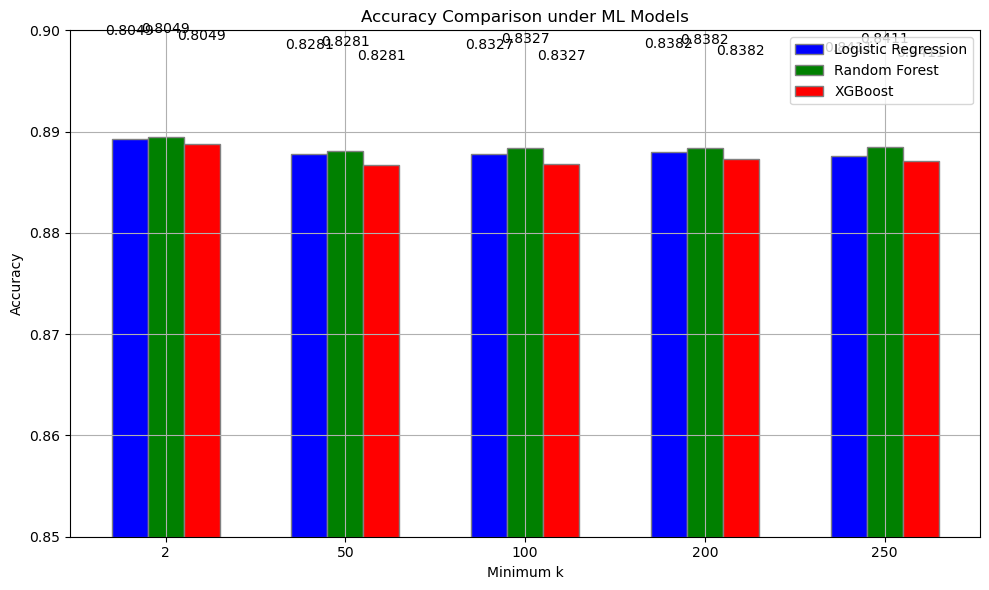

In [261]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data for the table
data = {
    'minimum k': [2, 50, 100, 200, 250],
    'P_29 Score': [0.80486, 0.82807, 0.83267, 0.83819, 0.84109],
    'Logistic Regression': [0.88928, 0.88782, 0.88782, 0.88797, 0.88757],
    'Random Forest': [0.88943, 0.88812, 0.88843, 0.88838, 0.88845],
    'XGBoost': [0.88877, 0.88673, 0.88680, 0.88725, 0.88710]
}

# Create DataFrame
df = pd.DataFrame(data)

# Define the number of models and number of bars
num_models = 3
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(df))  # positions for the first group of bars
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create figure and axis
plt.figure(figsize=(10, 6))

# Plotting bars
plt.bar(r1, df['Logistic Regression'], color='b', width=bar_width, edgecolor='grey', label='Logistic Regression')
plt.bar(r2, df['Random Forest'], color='g', width=bar_width, edgecolor='grey', label='Random Forest')
plt.bar(r3, df['XGBoost'], color='r', width=bar_width, edgecolor='grey', label='XGBoost')

# Adding P_29 Score as text above each bar
for i in range(len(df)):
    plt.text(r1[i], df['Logistic Regression'][i] + 0.01, f'{df["P_29 Score"][i]:.4f}', ha='center', va='bottom', fontsize=10)
    plt.text(r2[i], df['Random Forest'][i] + 0.01, f'{df["P_29 Score"][i]:.4f}', ha='center', va='bottom', fontsize=10)
    plt.text(r3[i], df['XGBoost'][i] + 0.01, f'{df["P_29 Score"][i]:.4f}', ha='center', va='bottom', fontsize=10)

# Adding labels and title
plt.xlabel('Minimum k')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison under ML Models')
plt.xticks([r + bar_width for r in range(len(df))], df['minimum k'])
plt.ylim([0.85, 0.9])
plt.legend()

# Show plot
plt.tight_layout()
plt.grid(True)
plt.show()
